# Extract secondary structure from PDB files easily and generate spreadsheet

<a rel="license" href="https://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://licensebuttons.net/l/by-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Author: Dr Antonia Mey   
Email: antonia.mey@ed.ac.uk

In [206]:
# Imports
import pandas as pd
import numpy as np
import glob 
import os
import urllib
from collections import Counter
import urllib
import json
import matplotlib.pylab as plt

In [203]:
!mamba install matplotlib seaborn --yes


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.2) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['matplotlib', 'seaborn']

[+] 0.0s
[+] 0.1s
conda-forge/osx-64 ━━━━━━━━━━━━━╸━━━━━━━━━━━   0.0 B / 

In [11]:
def get_alpha_helix_length_and_location(secondary_struc, min_length=8):
    helix_regions = []
    counter = 0
    curr_helix = []
    indexes = [i for i, x in enumerate(list(secondary_struc)) if x == 'H']
    for i in range(len(indexes)-1):
        difference = indexes[i+1]-indexes[i]
        if difference == 1:
            curr_helix.append(indexes[i])
            if i == len(indexes)-2:
                if len(curr_helix)>=min_length-1:
                    curr_helix.append(indexes[i+1])
                    helix_regions.append(curr_helix)
        else:
            curr_helix.append(indexes[i])
            if len(curr_helix)>=min_length-1:
                helix_regions.append(curr_helix)
            curr_helix = []
    return helix_regions

In [12]:
def count_serines(sequence):
    n_serine = sequence.count('S')
    if n_serine >=2:
        return 1
    else:
        return 0

In [13]:
def filter_helices(helix_index_list, known_things, sequence_length, discard_list= ['bHLH', 'Leucine-zipper'],overlap_threshold =4):
    '''
    Parameters:
    -----------
    helix_index_list : list
        2D list containing arrays of indexes where alpha helixes are
    known_things : dictionary
        extracted information from uniprot IDs around regions, domains and motives
    discard_list : list of Strings
        list that contains the identifiers to discard
    
    Returns:
    --------
    helix_index_list : list
        filtered list with correct helix indexes without the overlap
    Algorithm description:
    
    - generate a boolean array of all False of length of the sequence
    - for each annotation we want to check:
    - Add True between start and end of domains/regions we want to check in the boolean array
    - Then loop over helix list creating a boolean array of length sequence for each Helix section
    - Use logic and to compare regions boolean array with helix boolean array. 
    - If the number of over lap of Trues is larger than theshold x, remove this helix chunch from list and don't write to spreadsheet.
    '''
    
    bool_array =  np.zeros(sequence_length, dtype=bool)
    # alpha_helix_index_list = get_alpha_helix_length_and_location(sec_struc_output, min_length=7)
    helix_list_remove_index = []
    for key in known_things.keys():
        for entry in known_things[key]:
            bool_array =  np.zeros(sequence_length, dtype=bool)
            if entry[-1] in discard_list:
                bool_array[entry[0]-1:entry[1]] = True
            index = 0
            for a in helix_index_list:
                curr_helix =  np.zeros(sequence_length, dtype=bool)
                curr_helix[a] = True
                overalp = (np.sum(np.logical_and(bool_array, curr_helix)))
                if overalp>overlap_threshold:
                    helix_list_remove_index.append(index)
                index = index+1
    unique_idx = np.unique(helix_list_remove_index)
    for index in sorted(unique_idx, reverse=True):
        del helix_index_list[index]
    return helix_index_list

In [14]:
def annotating_helices(helix_index_list, known_things, sequence_length,overlap_threshold =4):
    '''
    Parameters:
    -----------
    helix_index_list : list
        2D list containing arrays of indexes where alpha helixes are
    known_things : dictionary
        extracted information from uniprot IDs around regions, domains and motives
    discard_list : list of Strings
        list that contains the identifiers to discard
    
    Returns:
    --------
    helix_index_list : list
        filtered list with correct helix indexes without the overlap
    Algorithm description:
    
    - generate a boolean array of all False of length of the sequence
    - for each annotation we want to check:
    - Add True between start and end of domains/regions we want to check in the boolean array
    - Then loop over helix list creating a boolean array of length sequence for each Helix section
    - Use logic and to compare regions boolean array with helix boolean array. 
    - If the number of over lap of Trues is larger than theshold x, remove this helix chunch from list and don't write to spreadsheet.
    '''
    annotations = [""]*len(helix_index_list)
    for key in known_things.keys():
        for entry in known_things[key]:
            # print(f'checking entry {entry}')
            bool_array =  np.zeros(sequence_length, dtype=bool)
            if entry[0] is None:
                continue
            elif entry[1] is None:
                continue
            bool_array[entry[0]-1:entry[1]] = True
            index = 0
            
            for a in helix_index_list:
                curr_helix =  np.zeros(sequence_length, dtype=bool)
                curr_helix[a] = True
                overalp = (np.sum(np.logical_and(bool_array, curr_helix)))
                if overalp>overlap_threshold:
                    # print(f'annotation found {entry[-1]}')
                    annotations[index] = annotations[index] +key+':'+entry[-1]+";"
                index = index+1
    return annotations

In [15]:
def get_domainn_region_info(data):
    known_things = {}
    known_things['Domain'] = []
    known_things['Region'] = []
    known_things['Motif'] = []
    #known_things['Helix'] = []
    if 'features' in data.keys():
        for d in data['features']:
            #print(d['type'])
            if d['type'] == 'Domain':
                known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            elif d['type'] == 'Region':
                known_things['Region'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            elif d['type'] == 'Motif':
                known_things['Motif'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            #elif d['type'] == 'Helix':
            #    known_things['Helix'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])

            
    return known_things       

In [16]:
def get_discrad_list(domain_f_name, region_f_name):
    # Getting domains
    domain_filter = []
    # This should go into a try thing!
    f = open(domain_f_name)
    f_content = f.readlines()
    f.close()

    for l in f_content:
        domain_filter.append(l.strip()) 
        
    # Getting regions
    region_filter = []
    f = open(region_f_name)
    f_content = f.readlines()
    f.close()

    for l in f_content:
        region_filter.append(l.strip())
    discard_list = np.hstack((region_filter,domain_filter))
    return discard_list

In [17]:
def generate_table_rows_for_uniprot_id(uni_prot_id, df, work_dir = 'temp', verbose = False, annotate = False):
    # print('Working on uniprot ID', uni_prot_id)
    # sec_struc_output = np.load('dssp_info/'+uni_prot_id+'.npy')
    # print('got secondary structure')
    #print(sec_struc_output)
    
    # Process uniprot file
    f = open('unique_ids/'+uni_prot_id+'.json')
    data = json.load(f)
    f.close()
    
    # print('read json file successfully')
    
    # Some basics:
    # checking keys
    keys = data.keys()
    
    # Primary Accession
    uni_id = 'NA'
    if 'primaryAccession' in keys:
        uni_id = data['primaryAccession'] 
        if verbose:
             print('uni_id',uni_id)
    else: 
        print('Issue: No primary Accession found')
    
    # Genes
    gene_name = 'NA'
    if 'genes' in keys:
        gene_name = data['genes'][0]['geneName']['value']
        if verbose:
            print('gene_name',gene_name)
    else:
        print('Issue: No gene found found')
    
    # getting the nucleotide sequenceID
    ref_seq_id = 'NA'
    if 'uniProtKBCrossReferences' in keys:
        for db in data['uniProtKBCrossReferences']:
            if db['database'] == "RefSeq":
                if '.' in db['properties'][0]['value']:
                    ref_seq_id = db['properties'][0]['value'].split('.')[0]
                else:
                    ref_seq_id = db['properties'][0]['value']
    if verbose:
        print('ref_seq_id',ref_seq_id)
    
    # getting sequence info
    sequence = 'NA'
    seq_length = 0
    if 'sequence' in keys:
        sequence = data['sequence']['value']
        if verbose:
            print('sequence',sequence)
    
        seq_length = data['sequence']['length']
        if seq_length != len(sequence):
            print(f"Warning for Uniprot id {uni_prot_id} sequence length recorded is not same as actual sequence")

    if seq_length == len(sec_struc_output):

        

        # Now lets get the helices:
        alpha_helix_index_list = get_alpha_helix_length_and_location(sec_struc_output, min_length=8)

        # Get the information of what domains and regions exist in the uniport id file:
        known_things = get_domainn_region_info(data)

        discard_list = ['PUM-HD', 'HEAT', 'ARM', 'bHLH', 'Leucine-zipper']
        discard_list = get_discrad_list('data/domain.csv', 'data/region_filter.csv')
        discard_list = []

        # Missing: Filter the alpha_helix_index_list
        filtered_helix_list=filter_helices(alpha_helix_index_list, known_things, seq_length, discard_list=discard_list,overlap_threshold =4)

        # annotate helices:
        if annotate:
            filtered_helix_list = alpha_helix_index_list
            annotations = annotating_helices(filtered_helix_list, known_things, seq_length,overlap_threshold =4)

        for i in range(len(filtered_helix_list)):
            firstAA_position_in_HELIDR = filtered_helix_list[i][0]+1
            lastAA_position_in_HELIDR = filtered_helix_list[i][-1]+1
            HELIDR_seq = sequence[filtered_helix_list[i][0]:filtered_helix_list[i][-1]+1]
            down_stream_seq = ''
            up_stream_seq = ''
            if filtered_helix_list[i][0]-10 >= 0 and filtered_helix_list[i][-1]+11 < len(sequence):
                # Note the +2 here does not include the last helix AA. 
                # We have to make sure here that we check the arrays are not out of bounds!
                down_stream_seq = sequence[filtered_helix_list[i][-1]+1:filtered_helix_list[i][-1]+11]
                up_stream_seq = sequence[filtered_helix_list[i][0]-10:filtered_helix_list[i][0]]
            elif alpha_helix_index_list[i][0]-10 <= 0:
                # Do we want a shorter version? 
                down_stream_seq = sequence[filtered_helix_list[i][-1]+1:filtered_helix_list[i][-1]+11]
                up_stream_seq = sequence[0:filtered_helix_list[i][0]]
            elif alpha_helix_index_list[i][-1]+11 > len(sequence):
                down_stream_seq = sequence[filtered_helix_list[i][-1]+2:len(sequence)+1]
                up_stream_seq = sequence[filtered_helix_list[i][0]-10:filtered_helix_list[i][0]]

            # This may need fixing if we have shorter upstream and downstream strings
            if len(down_stream_seq)==10 and len(up_stream_seq)==10: 
                Two_S5P_down = count_serines(down_stream_seq[:5])
                Two_S5P_up = count_serines(up_stream_seq[5:])
                # NOW we assemble the row:
                if annotate:
                    new_row = [uni_id,gene_name,ref_seq_id,firstAA_position_in_HELIDR,lastAA_position_in_HELIDR,up_stream_seq,HELIDR_seq,
                          down_stream_seq,Two_S5P_up,Two_S5P_down,'','','','','','','','','',annotations[i]]
                else:
                    new_row = [uni_id,gene_name,ref_seq_id,firstAA_position_in_HELIDR,lastAA_position_in_HELIDR,up_stream_seq,HELIDR_seq,
                          down_stream_seq,Two_S5P_up,Two_S5P_down,'','','','','','','','','']
                df.loc[len(df)] = new_row
            else:
                # We may want to revisit this continue here
                continue
        return df, None
            
    else:
        # print(f'sequence length from structure is {seq_length}, from alpha fold {len(sec_struc_output)}')
        # print("there is an incompatibility between the sequence and alpha fold structure")
        # print(f'the current uniprotid with the issue is: {uni_prot_id}')
        return df, uni_prot_id

In [154]:
def feature_in_domain(domain_mask, start, end, percent_overlap=50):
    second_bool_array = np.zeros(len(domain_mask), dtype=bool)
    second_bool_array[start:end] = True
    overlap = (np.sum(np.logical_and(domain_mask, second_bool_array)))
    if overlap/(end-start)*100>=percent_overlap:
        return True
    else:
        return False 
    

In [150]:
def get_domain_mask(domain_dic, sequence_length):
    bool_array =  np.zeros(sequence_length, dtype=bool)
    for key in domain_dic.keys():
        for entry in known_things[key]:
            # print(f'checking entry {entry}')
    
            if entry[0] is None:
                continue
            elif entry[1] is None:
                continue
            bool_array[entry[0]-1:entry[1]] = True
    return bool_array

In [148]:
def get_domain_name(start, end, domain_dic):
    for d in domain_dic['Domain']:
        if (max(0, min(d[1], end) - max(d[0], start)))>0:
            return d[2]

## Testing things out

In [191]:
f = open('data_idr/expressed_uni_prot_ids.txt', 'r')
f_content = f.readlines()
f.close()

In [2]:
ids = []
for f in f_content:
    ids.append(f.strip())

In [163]:
fail_list = []
verbose = False

In [151]:
# Process uniprot file
f = open('unique_ids/'+ids[21]+'.json')
data = json.load(f)
f.close()

# print('read json file successfully')

# Some basics:
# checking keys
keys = data.keys()

# Primary Accession
uni_id = 'NA'
if 'primaryAccession' in keys:
    uni_id = data['primaryAccession'] 
    if verbose:
         print('uni_id',uni_id)
else: 
    print('Issue: No primary Accession found')

# Genes
gene_name = 'NA'
if 'genes' in keys:
    gene_name = data['genes'][0]['geneName']['value']
    if verbose:
        print('gene_name',gene_name)
else:
    print('Issue: No gene found found')

uni_id A0PJY2
gene_name FEZF1


In [215]:
desired_features = ['Beta strand','Helix','Turn']

# get domain inforamtion
known_things = {}
known_things['Domain'] = []
final_table_list = []    
            
            
# loop over all uniprot ids
for i in range(len(ids)):
#for i in range(20):
    # Process uniprot file
    fname = 'unique_ids/'+ids[i]+'.json'


    if os.path.isfile(fname):
        f = open(fname)
        data = json.load(f)
        f.close()
        keys = data.keys()

        sequence_length = data['sequence']['length']

        # populate dictionary:
        #print(f"sequence length is: {sequence_length}")
        gene_name = 'NA'
        if 'genes' in keys:
            gene_name = data['genes'][0]['geneName']['value']
            
        #print(f"gene name: {gene_name}")
        
        uni_id = 'NA'
        if 'primaryAccession' in keys:
            uni_id = data['primaryAccession'] 
        #print('uni_id',uni_id)
    

        if 'features' in keys:
            
            # populate domain information
            for d in data['features']:
                #print(d['type'])
                if d['type'] == 'Domain':
                    known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            domain_mask = get_domain_mask(known_things,sequence_length)

            if len(final_table_list)>0:
                final_table_list[-1]['gap'] = final_table_list[-1]['sequence length']-final_table_list[-1]['end']
            
            # now check secondary structure features and if there is overlap
            starts = []
            ends = []
            count = 0
            for f in data['features']:
                if f['type'] in desired_features:
                    final_table_dic = {}
                    # print('=====New feature====')
                    # print(f['type'])

                    start = f['location']['start']['value']
                    end = f['location']['end']['value']

                    # Check if features is in domain
                    if feature_in_domain(domain_mask, start, end, percent_overlap=50):
                        domain_feature_overalp = 'Yes'
                        domain_name = get_domain_name(start,end,known_things)
                    else:
                        domain_feature_overalp = 'No'  
                        domain_name = 'None'
                    

                    if len(ends)>0:
                        gap = start-ends[-1]-1
                    elif count == len(data['features'])-1:
                        print('this happens')
                        gap = (sequence_length-end)-1
                    else:
                        gap = start - 1
                    feature_length = end - start
                    final_table_dic['gene name'] = gene_name
                    final_table_dic['Uniprot ID'] = uni_id
                    final_table_dic['sequence length'] = sequence_length
                    final_table_dic['Feature name'] = f['type']
                    final_table_dic['start'] = start
                    final_table_dic['end'] = end
                    final_table_dic['length'] = feature_length
                    final_table_dic['gap'] = gap
                    final_table_dic['Overlap with domain'] = domain_feature_overalp
                    final_table_dic['Domain name'] = domain_name
                    if verbose: 
                        print(f"start: {start}")
                        print(f"end: {end}")
                        print(f"length: {feature_length}")
                        print(f"gap: {gap}")
                        print(f"Domain feature overlap: {domain_feature_overalp}")
                        print(f"domain name: {domain_name}")
                    starts.append(start)
                    ends.append(end)
                    final_table_list.append(final_table_dic)
                    count+=1
            starts = np.array(starts)
            ends = np.array(ends)
            gaps = (starts[1:-1]-ends[0:-2])-1



In [216]:
df = pd.DataFrame(final_table_list)  

In [220]:
df

,gene name,Uniprot ID,sequence length,Feature name,start,end,length,gap,Overlap with domain,Domain name
0,RBM47,A0AV96,593,Beta strand,150,156,6,149,Yes,Protein kinase
1,RBM47,A0AV96,593,Helix,164,174,10,7,Yes,Protein kinase
2,RBM47,A0AV96,593,Beta strand,178,182,4,3,Yes,Protein kinase
3,RBM47,A0AV96,593,Beta strand,185,187,2,2,Yes,Protein kinase
4,RBM47,A0AV96,593,Turn,189,193,4,1,Yes,Protein kinase
...,...,...,...,...,...,...,...,...,...,...
152900,RWDD2A,Q9UIY3,292,Beta strand,86,90,4,9,Yes,Protein kinase
152901,RWDD2A,Q9UIY3,292,Beta strand,92,94,2,1,Yes,Protein kinase
152902,RWDD2A,Q9UIY3,292,Helix,96,110,14,1,Yes,Protein kinase
152903,RWDD2A,Q9UIY3,292,Helix,120,129,9,9,Yes,Protein kinase


In [217]:
df.to_csv('trial_table.csv', index=False)

(array([8.9631e+04, 3.6522e+04, 1.0922e+04, 3.9410e+03, 1.8430e+03,
        1.0300e+03, 8.0300e+02, 6.3500e+02, 5.2400e+02, 4.3900e+02,
        3.3100e+02, 2.8900e+02, 2.4400e+02, 2.2400e+02, 1.8100e+02,
        2.0300e+02, 1.6500e+02, 1.3300e+02, 1.2300e+02, 1.2900e+02,
        1.0700e+02, 1.1700e+02, 9.7000e+01, 9.8000e+01, 7.6000e+01,
        8.1000e+01, 9.6000e+01, 7.2000e+01, 6.2000e+01, 8.8000e+01,
        8.4000e+01, 7.0000e+01, 6.0000e+01, 6.6000e+01, 6.7000e+01,
        6.3000e+01, 5.6000e+01, 6.2000e+01, 4.6000e+01, 5.0000e+01,
        4.3000e+01, 5.2000e+01, 3.9000e+01, 5.4000e+01, 4.4000e+01,
        3.9000e+01, 4.2000e+01, 4.1000e+01, 3.4000e+01, 4.3000e+01]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 18

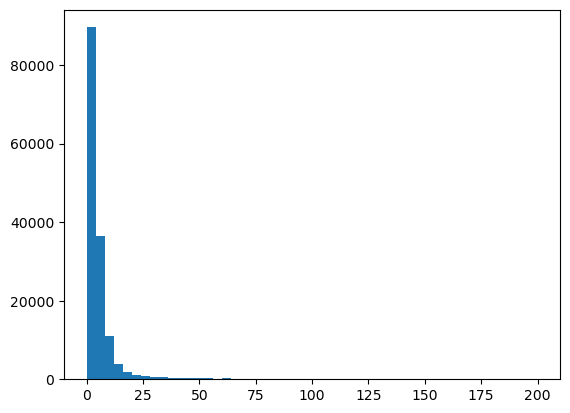

In [219]:
plt.hist(df['gap'], range=[0,200], bins=50)

### Getting list of uniprot IDS that are expressed in cells

In [181]:
df = pd.read_csv('filtered_table_final_100223.csv')

In [183]:
selected_rows = df[df['HEK293T_expressed'] == 1]

In [190]:
ids_to_be_used = selected_rows['uniprot_id'].values
ids_to_be_used = np.unique(ids_to_be_used)
f = open('data_idr/expressed_uni_prot_ids.txt','w')
for uni in ids_to_be_used:
    f.write(uni+'\n')
f.close()